In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from scipy.special import sph_harm
import pandas as pd
from scipy.special import sph_harm
from matplotlib import cm
from inertia_tensor_from_smiles import smiles_to_inertia_tensor

# Constants
h = 6.62607015e-34  # Planck's constant in J·s
MHz_conv = 1e-6     # Convert Hz to MHz

def rotational_prefactor(I):
    """
    Given a moment of inertia in amu·Å², return the rotational energy prefactor in MHz.
    Uses E = h / (8 * pi^2 * I) in Hz, then converts to MHz.
    """
    return (h / (8 * np.pi**2 * I)) * (1 / h) * MHz_conv
"""
inertia_tensor = np.array([
    [2.0e-46, 0.1e-46, 0.0],
    [0.1e-46, 1.5e-46, 0.0],
    [0.0,     0.0,     1.0e-46]
])"""


'\ninertia_tensor = np.array([\n    [2.0e-46, 0.1e-46, 0.0],\n    [0.1e-46, 1.5e-46, 0.0],\n    [0.0,     0.0,     1.0e-46]\n])'

In [2]:
#selfies = '[H][H]'
#selfies = '[C][Cl][H][H][H]' # symmetric top

#linear rotors
#smiles = 'H[H]'
#smiles = 'N#N'
#smiles = 'C#O'
#smiles = 'O=C=O'

#symm tops
#smiles = 'C(Cl)(H)(H)'
#smiles = 'C(I)(H)(H)'
#smiles = 'N(H)(H)(H)'

#oblate
#smiles = 'c1ccccc1'
#smiles = 'F[B](F)F'

#assym tops
smiles = 'CC=O'

#isotopes
#smiles = '[2H][2H]'
#smiles = 'O=[13C]=O'
#smiles = '[13CH4]'


inertia_tensor = smiles_to_inertia_tensor(smiles)
print(inertia_tensor)

[[16.7856476  18.07381683 -4.82091666]
 [18.07381683 60.31246347  3.58567175]
 [-4.82091666  3.58567175 71.71101785]]


In [3]:
# Step 1: Compute principal moments from SMILES
tensor = smiles_to_inertia_tensor(smiles)
eigenvals, eigenvecs = np.linalg.eigh(tensor)
I1, I2, I3 = eigenvals
eigenvals

array([ 9.70016826, 66.70050142, 73.10412141])

In [4]:
def rotor_classification(I1, I2, I3, tol=1e-3):
    if min(I1, I2, I3) < tol:
        return 'linear'
    elif abs(I1 - I2) / max(I1, I2) < tol or abs(I1 - I3) / max(I1, I3) < tol or abs(I2 - I3) / max(I2, I3) < tol:
        return 'symmetric'
    else:
        return 'asymmetric'

In [5]:
rotor_classification(I1, I2, I3, tol=1e-3)

'asymmetric'

In [ ]:
# Step 2: Generate the |J, K, M⟩ basis
def generate_JKM_basis(J_max):
    basis = []
    for J in range(J_max + 1):
        for M in range(-J, J + 1):
            for K in range(-J, J + 1):
                basis.append((J, K, M))
    return basis

J_max = 2
basis = generate_JKM_basis(J_max)
dim = len(basis)

# Step 3: Build the asymmetric rotor Hamiltonian in MHz
def build_rotor_H_MHz_no_diag(basis, I1, I2, I3):
    H = np.zeros((dim, dim))
    for i, (J, K, M) in enumerate(basis):
        E_diag = (
            K**2 * rotational_prefactor(I3) +
            (J*(J+1) - K**2) * 0.5 * (rotational_prefactor(I1) + rotational_prefactor(I2))
        )
        H[i, i] = E_diag
    return H

def build_rotor_H_MHz(basis, I1, I2, I3):
    """
    Construct the appropriate rotor Hamiltonian in the |J,K,M⟩ basis,
    handling symmetric tops and near-degeneracies to avoid instabilities.
    Energy units are in MHz, and moments of inertia must be in amu·Å².
    Assumes rotor_classification(I1, I2, I3) is defined.
    """
    dim = len(basis)
    H = np.zeros((dim, dim))

    def pref(I):  # rotational prefactor in MHz
        I = max(I, 1e-10)
        return (h / (8 * np.pi**2 * I)) * (1 / h) * MHz_conv

    rotor_type = rotor_classification(I1, I2, I3)

    if rotor_type == 'symmetric':
        # Average the degenerate moments
        I1 = I2 = 0.5 * (I1 + I2)
        for i, (J, K, M) in enumerate(basis):
            E_diag = (
                K**2 * pref(I3) +
                (J * (J + 1) - K**2) * pref(I1)
            )
            H[i, i] = E_diag

    elif rotor_type == 'linear':
        # Simplified symmetric top: assume no K-mixing and K = 0
        for i, (J, K, M) in enumerate(basis):
            if K != 0:
                continue
            E_diag = J * (J + 1) * pref(I1)  # assume I1 = I2, I3 very small
            H[i, i] = E_diag

    elif rotor_type == 'asymmetric':
        for i, (J, K, M) in enumerate(basis):
            E_diag = (
                K**2 * pref(I3) +
                (J * (J + 1) - K**2) * 0.5 * (pref(I1) + pref(I2))
            )
            H[i, i] = E_diag

            # Off-diagonal elements: K ↔ K ± 2
            for j, (Jp, Kp, Mp) in enumerate(basis):
                if J != Jp or M != Mp:
                    continue
                if Kp == K + 2 or Kp == K - 2:
                    delta_K = Kp - K
                    term = 0.25 * (pref(I1) - pref(I2))
                    A = (J * (J + 1) - K * (K + delta_K))
                    B = (J * (J + 1) - (K + delta_K) * (K + 2 * delta_K))
                    if A >= 0 and B >= 0:
                        matrix_element = np.sqrt(A * B)
                        value = term * matrix_element
                        H[i, j] += value
                        H[j, i] += value

    else:
        raise ValueError(f"Unknown rotor type: {rotor_type}")

    return H

In [7]:
H = build_rotor_H_MHz(basis, I1, I2, I3)

# Step 4: Diagonalize to obtain energy levels and eigenstates
e_vals, e_vecs = eigh(H)

# Step 5: Format output as a labeled DataFrame
spectra = []
for idx, energy in enumerate(e_vals):
    state_components = []
    for coeff, (J, K, M) in zip(e_vecs[:, idx], basis):
        if abs(coeff) > 0.1:
            state_components.append(f"{coeff:+.2f}|{J},{K},{M}>")
    spectra.append({
        "Index": idx,
        "Energy (MHz)": energy,
        "Eigenstate": " + ".join(state_components)
    })

df_spectra = pd.DataFrame(spectra)
df_spectra

,Index,Energy (MHz),Eigenstate
0,0,0.000000e+00,"+1.00|0,0,0>"
1,1,7.064863e-10,"+0.60|2,-2,-2> + -0.53|2,0,-2> + +0.60|2,2,-2>"
2,2,7.064863e-10,"+0.60|2,-2,-1> + -0.53|2,0,-1> + +0.60|2,2,-1>"
3,3,7.064863e-10,"+0.60|2,-2,0> + -0.53|2,0,0> + +0.60|2,2,0>"
4,4,7.064863e-10,"+0.60|2,-2,1> + -0.53|2,0,1> + +0.60|2,2,1>"
5,5,7.064863e-10,"+0.60|2,-2,2> + -0.53|2,0,2> + +0.60|2,2,2>"
6,6,9.210198e-10,"+1.00|1,1,0>"
7,7,9.210198e-10,"+1.00|1,-1,1>"
8,8,9.210198e-10,"+1.00|1,1,1>"
9,9,9.210198e-10,"+1.00|1,-1,-1>"


In [8]:
def visualize_rotational_state_wigner(df, basis, state_index):
    """
    Visualize a rotational eigenstate with arbitrary M using spherical harmonics approximation.
    Dynamically detects dominant J and includes all M. Warns and skips states that cannot be visualized.
    """
    # Retrieve the eigenvector
    coeffs = df.loc[state_index, 'Eigenstate']
    if coeffs.strip() == "":
        print("Empty eigenstate — nothing to visualize.")
        return

    # Reconstruct the eigenvector
    components = coeffs.split('+')
    vec = np.zeros(len(basis), dtype=complex)
    for c in components:
        if not c.strip(): continue
        coef_part, state_part = c.strip().split('|')
        coef = complex(coef_part)
        J, K, M = map(int, state_part[:-1].split(','))
        idx = basis.index((J, K, M))
        vec[idx] = coef

    # Step 1: Detect dominant J in eigenstate
    J_counts = {}
    for i, coeff in enumerate(vec):
        if abs(coeff) > 1e-3:
            Jb = basis[i][0]
            J_counts[Jb] = J_counts.get(Jb, 0) + abs(coeff)
    if not J_counts:
        print("⚠️ No usable components in eigenstate.")
        return
    J = max(J_counts, key=J_counts.get)

    # Spherical grid
    theta = np.linspace(0, np.pi, 200)
    phi = np.linspace(0, 2 * np.pi, 200)
    PHI, THETA = np.meshgrid(phi, theta)

    # Step 2: Build approximate wavefunction
    psi = np.zeros_like(PHI, dtype=complex)
    included = []
    for i, (Jb, Kb, Mb) in enumerate(basis):
        if Jb != J:
            continue
        amp = vec[i]
        if abs(amp) < 1e-3:
            continue
        try:
            yjk = sph_harm(Kb, J, PHI, THETA)
            psi += amp * yjk
            included.append((Jb, Kb, Mb))
        except Exception as e:
            print(f"⚠️ Failed to include component |{Jb},{Kb},{Mb}>: {e}")

    if np.allclose(np.abs(psi), 0):
        print(f"⚠️ Eigenstate {state_index} contains no valid components for visualization.")
        return

    print("Included components:", included)

    # Normalize and plot
    R = np.abs(psi)**2
    R /= R.max()

    X = R * np.sin(THETA) * np.cos(PHI)
    Y = R * np.sin(THETA) * np.sin(PHI)
    Z = R * np.cos(THETA)

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, facecolors=cm.viridis(R), rstride=3, cstride=3, antialiased=False)
    ax.set_title(f'Rotational eigenstate index={state_index} (approx. via Y_J^K sum for J={J})')
    ax.set_box_aspect([1, 1, 1])
    ax.axis('off')
    plt.show()


C:\Users\ma1180357\AppData\Local\Temp\ipykernel_33156\941736686.py:49: DeprecationWarning: `scipy.special.sph_harm` is deprecated as of SciPy 1.15.0 and will be removed in SciPy 1.17.0. Please use `scipy.special.sph_harm_y` instead.
  yjk = sph_harm(Kb, J, PHI, THETA)


Included components: [(2, -1, -1), (2, 1, -1)]


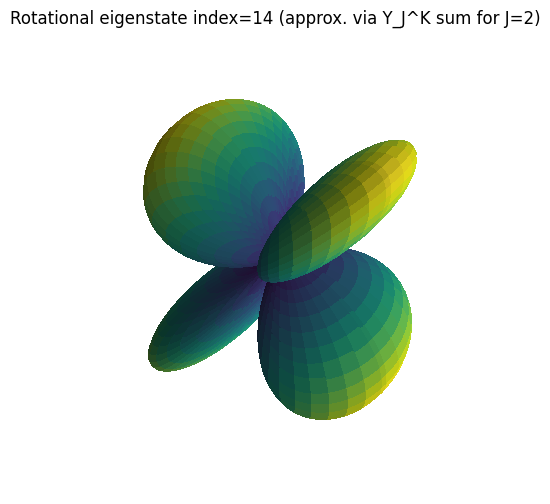

In [14]:
visualize_rotational_state_wigner(df_spectra, basis, state_index=14)


In [10]:
# Re-import necessary packages after code execution state reset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sympy as sp
from sympy.physics.wigner import wigner_d
from sympy import cos, sin, pi
from matplotlib import cm

def visualize_axis_distribution(df, basis, state_index, resolution=100):
    """
    Computes and visualizes the probability distribution over lab-frame directions
    of the body-fixed z-axis for a given eigenstate (from df) using full Wigner D functions.
    """
    coeffs = df.loc[state_index, 'Eigenstate']
    if coeffs.strip() == "":
        print("Empty eigenstate — nothing to visualize.")
        return

    # Parse coefficients
    vec = np.zeros(len(basis), dtype=complex)
    for c in coeffs.split('+'):
        if not c.strip(): continue
        coef_part, state_part = c.strip().split('|')
        coef = complex(coef_part)
        J, K, M = map(int, state_part[:-1].split(','))
        idx = basis.index((J, K, M))
        vec[idx] = coef

    # Extract dominant J
    J_values = [basis[i][0] for i, v in enumerate(vec) if abs(v) > 1e-3]
    if not J_values:
        print("No usable components.")
        return
    J = max(set(J_values), key=J_values.count)

    # Set up grid over (theta, phi)
    theta_vals = np.linspace(0, np.pi, resolution)
    phi_vals = np.linspace(0, 2 * np.pi, resolution)
    THETA, PHI = np.meshgrid(theta_vals, phi_vals)

    # Compute probability density over sphere
    P = np.zeros_like(THETA, dtype=np.float64)

    gamma_vals = np.linspace(0, 2 * np.pi, 50)
    for i in range(resolution):
        for j in range(resolution):
            theta = THETA[i, j]
            phi = PHI[i, j]
            prob_density = 0
            for gamma in gamma_vals:
                psi = 0
                for idx, (Jb, Kb, Mb) in enumerate(basis):
                    if Jb != J:
                        continue
                    coef = vec[idx]
                    if abs(coef) < 1e-3:
                        continue
                    D_val = sp.N(wigner_d(J, Mb, Kb, theta))[Mb + J, Kb + J]
                    D = D_val * sp.exp(-sp.I * Mb * phi) * sp.exp(-sp.I * Kb * gamma)
                    psi += coef * D
                prob_density += abs(psi)**2
            P[i, j] = float(sp.re(prob_density.evalf())) / len(gamma_vals)


    # Normalize
    P /= np.max(P)

    # Spherical to Cartesian
    X = P * np.sin(THETA) * np.cos(PHI)
    Y = P * np.sin(THETA) * np.sin(PHI)
    Z = P * np.cos(THETA)

    # Plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, facecolors=cm.viridis(P), rstride=2, cstride=2, antialiased=False)
    ax.set_title(f'Distribution of body z-axis direction (state {state_index})')
    ax.set_box_aspect([1, 1, 1])
    ax.axis('off')
    plt.show()


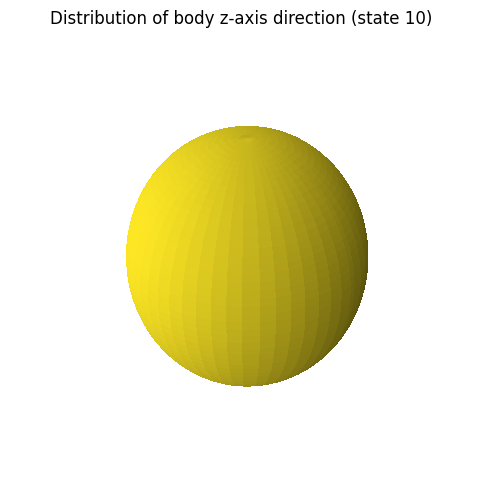

In [11]:
visualize_axis_distribution(df_spectra, basis, state_index=10)
